In [1]:
import tensorflow as tf

assert tf.__version__ >= "2.0"

import keras_tuner as kt
import numpy as np
import torch
import random

tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

import matplotlib.pyplot as plt

import cv2

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import argparse
import os

import torchvision.transforms as transforms

import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import tensor

2024-07-26 13:11:34.664057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 13:11:34.673615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 13:11:34.686682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 13:11:34.690195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 13:11:34.699360: I tensorflow/core/platform/cpu_feature_guar

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--n_classes", type=int, default=2, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args(args=[])

img_shape = (opt.channels, opt.img_size, opt.img_size)

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

In [4]:
def print_accuracy_scores(train_labels, test_labels, predictions_train_model, predictions_test_model):
    acc_train = accuracy_score(train_labels, predictions_train_model)
    acc_test = accuracy_score(test_labels, predictions_test_model)
    print('Training set accuracy:   {:.3f}'.format(acc_train))
    print('Test set accuracy:       {:.3f}'.format(acc_test))

def print_stats(labels, predictions, title):
    meas = precision_recall_fscore_support(labels, predictions, average=None, zero_division= np.nan)
    print(title)
    for i in range(2):
        print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={3:5.3f}'.format(i, meas[0][i], meas[1][i], meas[2][i]))

class StopExecution(Exception):
    def _render_traceback_(self):
        return []

In [5]:
X = np.load("pneumonia_images.npy")
y = (np.load("pneumonia_labels.npy")).ravel()

if (len(X) != len(y)):
    raise ValueError("Numbers of images and labels do not match")

print(f"The dataset is composed by {X.shape[0]} images {X.shape[1]}x{X.shape[2]}")

bin_count = np.bincount(y)
if len(bin_count) != 2:
    raise ValueError("Labels must be 0 or 1")

print("Negative examples: ", bin_count[0]) 
print("Positive examples: ", bin_count[1])

if bin_count[0] != bin_count[1]:
    print("Imbalanced Dataset")
else:
    print("Balanced Dataset")

The dataset is composed by 5232 images 28x28
Negative examples:  1349
Positive examples:  3883
Imbalanced Dataset


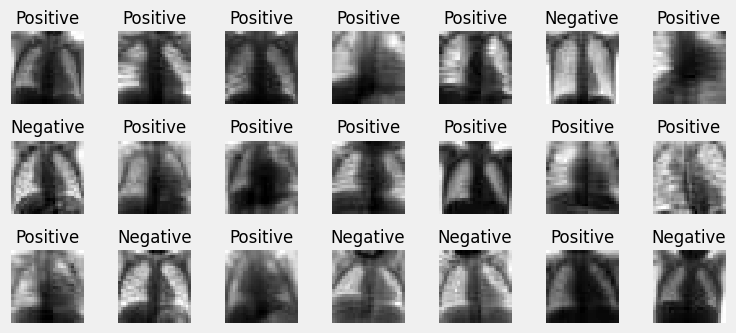

In [6]:
n_rows = 3
n_cols = 7
titles = ["Negative", "Positive"]
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(titles[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [7]:
cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [8]:
# Configure data loader
X = np.load("pneumonia_images.npy")
y = (np.load("pneumonia_labels.npy")).ravel()

data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])]
)

class MNISTCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        image = self.transform(np.array(image))
        return image, label
    def __len__(self):
        return len(self.labels)

dataset = MNISTCustomDataset(X, y, data_transform)

dataloader = DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [9]:
if os.path.isfile('./generator_weights') and os.path.isfile('./discriminator_weights'):
    generator.load_state_dict(torch.load("./generator_weights"))
    discriminator.load_state_dict(torch.load("./discriminator_weights"))
    raise StopExecution
    
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (images, labels) in enumerate(dataloader):
        batch_size = images.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_images = Variable(images.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_images = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_images, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_images, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_images.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i

StopExecution: 

In [10]:
if not os.path.isfile('./generator_weights') and not os.path.isfile('./discriminator_weights'):
    torch.save(generator.state_dict(), "./generator_weights")
    torch.save(discriminator.state_dict(), "./discriminator_weights")

In [11]:
X_real_negative = []
X_real_positive = []

for i, x in enumerate(X):
    if y[i] == 0:
        X_real_negative.append(x)
    else:
        X_real_positive.append(x)

X_real_negative = np.asarray(X_real_negative)
X_real_positive = np.asarray(X_real_positive)

noise = np.random.normal(0, 50, X_real_negative.shape)
X_real_negative = X_real_negative + noise
X_real_negative = np.clip(X_real_negative, 0, 255).astype(np.uint8)

noise = np.random.normal(0, 50, X_real_positive.shape)
X_real_positive = X_real_positive + noise
X_real_positive = np.clip(X_real_positive, 0, 255).astype(np.uint8)

negative_fake_to_gen = 5000-len(X_real_negative)
positive_fake_to_gen = 5000-len(X_real_positive)

In [12]:
z = Variable(FloatTensor(np.random.normal(0, 50, (negative_fake_to_gen, opt.latent_dim))))
labels = np.zeros(negative_fake_to_gen)
labels = Variable(LongTensor(labels))
gen_images = generator(z, labels)
gen_images = gen_images.detach().cpu().numpy()
X_fake_negative = np.ndarray((negative_fake_to_gen, 28, 28))
for i in range(negative_fake_to_gen):
    X_fake_negative[i] = gen_images[i].reshape((28,28))
X_fake_negative = (X_fake_negative-np.min(X_fake_negative))/(np.max(X_fake_negative)-np.min(X_fake_negative))

/tmp/ipykernel_7610/338800018.py:1: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  z = Variable(FloatTensor(np.random.normal(0, 50, (negative_fake_to_gen, opt.latent_dim))))


In [13]:
z = Variable(FloatTensor(np.random.normal(0, 50, (positive_fake_to_gen, opt.latent_dim))))
labels = np.ones(positive_fake_to_gen)
labels = Variable(LongTensor(labels))
gen_images = generator(z, labels)
gen_images = gen_images.detach().cpu().numpy()
X_fake_positive = np.ndarray((positive_fake_to_gen, 28, 28))
for i in range(positive_fake_to_gen):
    X_fake_positive[i] = gen_images[i].reshape((28,28))
X_fake_positive = (X_fake_positive-np.min(X_fake_positive))/(np.max(X_fake_positive)-np.min(X_fake_positive))

In [14]:
X_fake_negative = np.clip(X_fake_negative * 255, 0, 255).astype(np.uint8)
X_fake_positive = np.clip(X_fake_positive * 255, 0, 255).astype(np.uint8)

In [15]:
balanced_dataset = np.concatenate((X_real_negative, X_fake_negative, X_real_positive, X_fake_positive))
labels_positive = np.ones(5000)
labels_negative = np.zeros(5000)
labels = np.concatenate((labels_negative, labels_positive))

In [16]:
def extract_histogram(image, color_space, channels=(0,1,2), bins=(8, 8, 8), range=(0, 256, 0, 256, 0, 256)):
    if color_space is None:
        cvt_img = image
    else:
        cvt_img = cv2.cvtColor(image, color_space)
    hist = cv2.calcHist([cvt_img], channels, None, bins, range)
    cv2.normalize(hist, hist)
    return hist.flatten()

def get_histograms(dataset, color_space, channels, bins, channels_range):
    histograms = []
    for x in dataset:
            hist = extract_histogram(x, color_space, channels, bins, channels_range)
            histograms.append(hist)
    return histograms

def ranges(N, nb):
    step = N / nb
    return ["{},{}".format(round(step*i), round(step*(i+1))) for i in range(nb)]

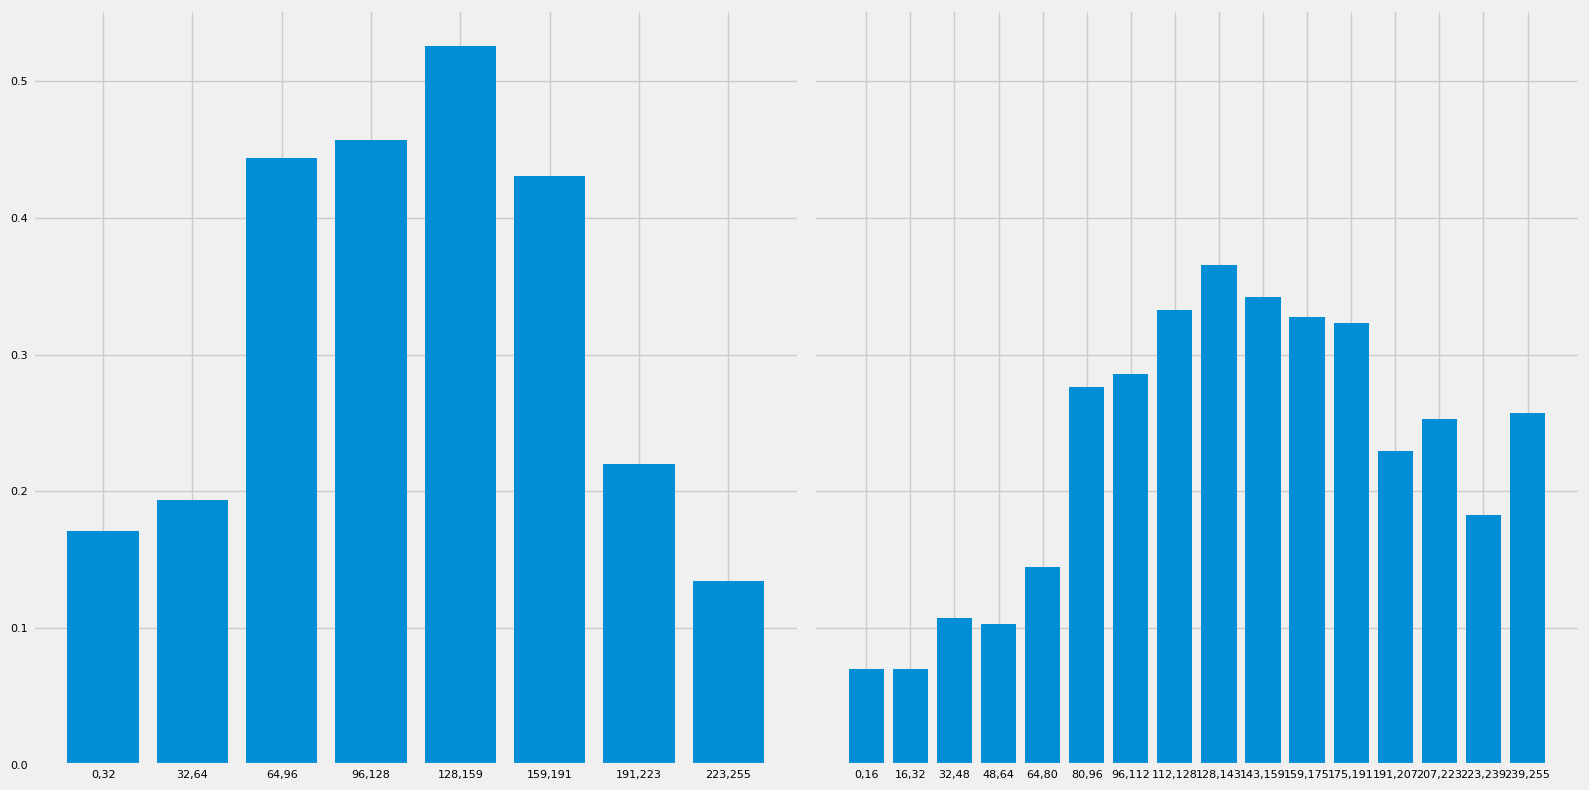

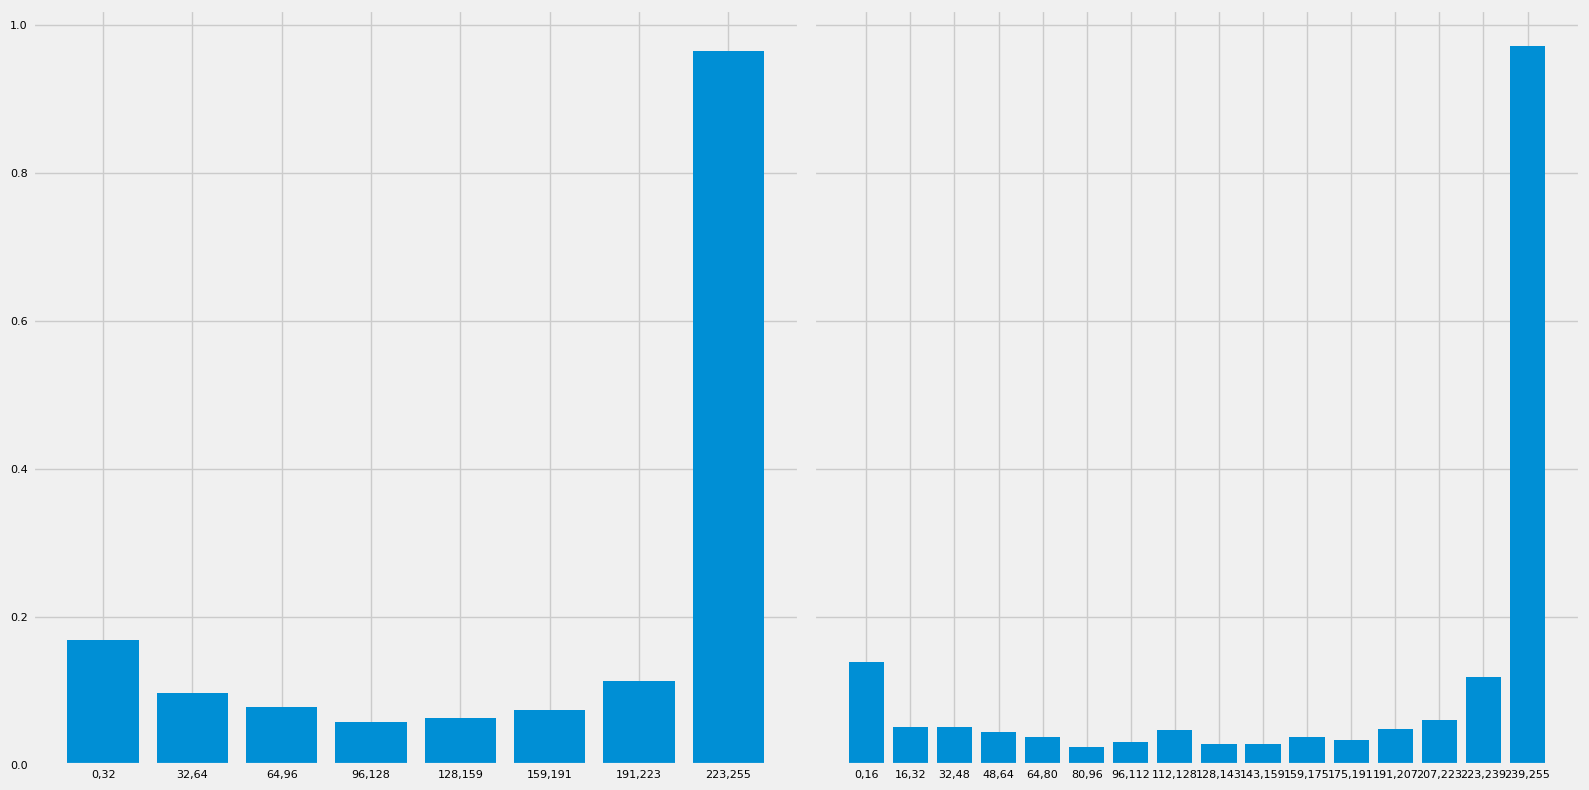

In [17]:
hist8bins_real = extract_histogram(X_real_negative[random.randint(0, len(X_real_negative))], None, (0,), (8,), (0, 256))
hist16bins_real = extract_histogram(X_real_negative[random.randint(0, len(X_real_negative))], None, (0,), (16,), (0, 256))
hist8bins_fake = extract_histogram(X_fake_negative[random.randint(0, len(X_fake_negative))], None, (0,), (8,), (0, 256))
hist16bins_fake = extract_histogram(X_fake_negative[random.randint(0, len(X_fake_negative))], None, (0,), (16,), (0, 256))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins_real)
axs[1].bar(ranges(255, 16), hist16bins_real)
plt.show()
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins_fake)
axs[1].bar(ranges(255, 16), hist16bins_fake)
plt.show()

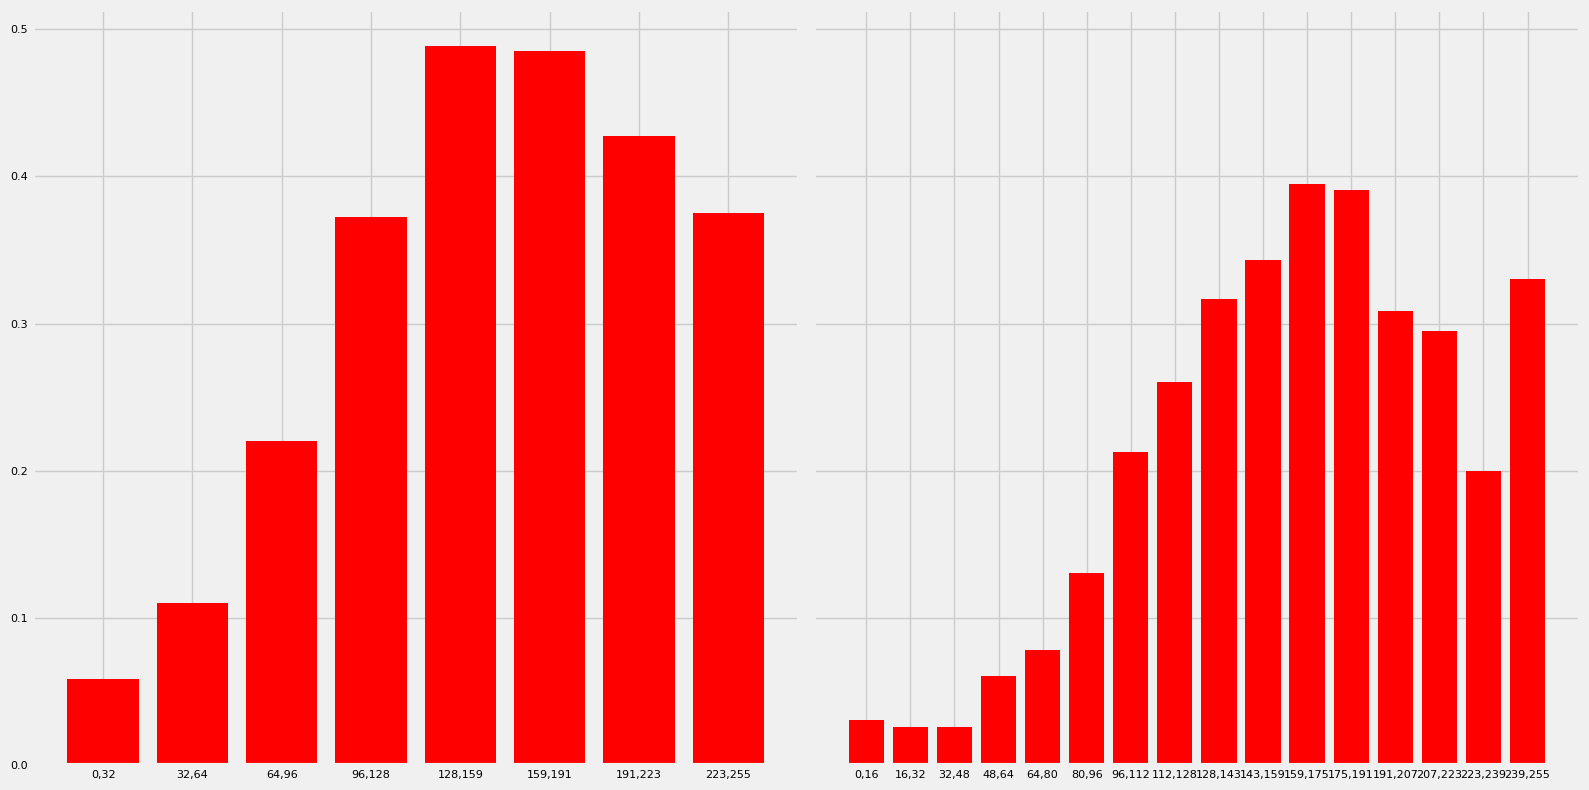

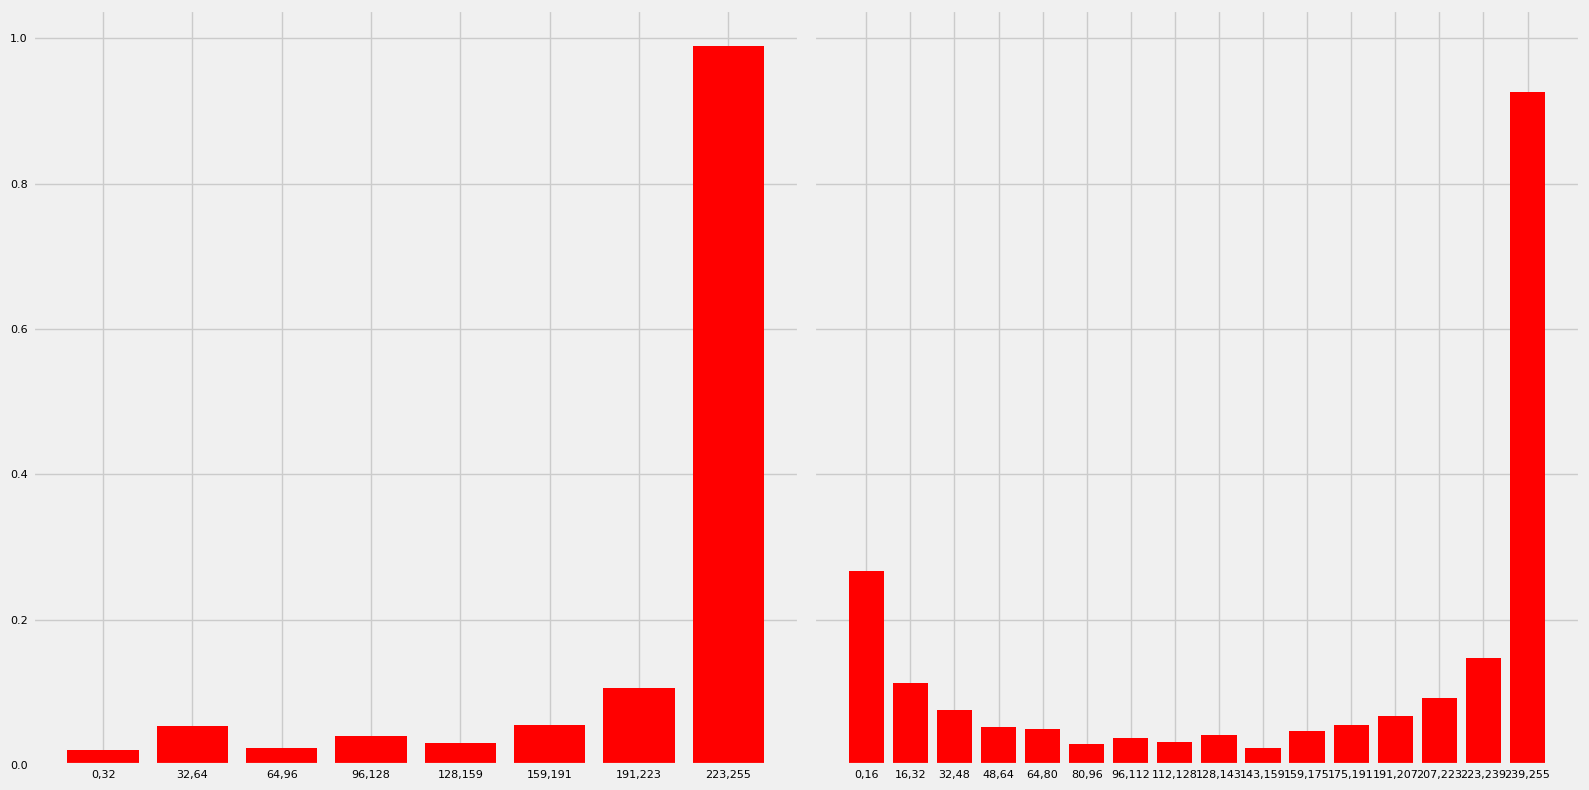

In [18]:
hist8bins_real = extract_histogram(X_real_positive[random.randint(0, len(X_real_positive))], None, (0,), (8,), (0, 256))
hist16bins_real = extract_histogram(X_real_positive[random.randint(0, len(X_real_positive))], None, (0,), (16,), (0, 256))
hist8bins_fake = extract_histogram(X_fake_positive[random.randint(0, len(X_fake_positive))], None, (0,), (8,), (0, 256))
hist16bins_fake = extract_histogram(X_fake_positive[random.randint(0, len(X_fake_positive))], None, (0,), (16,), (0, 256))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins_real, color="red")
axs[1].bar(ranges(255, 16), hist16bins_real, color="red")
plt.show()
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins_fake, color="red")
axs[1].bar(ranges(255, 16), hist16bins_fake, color="red")
plt.show()

In [19]:
bins_8 = np.array(get_histograms(balanced_dataset, None, (0,), (8,), (0, 256)))
bins_16 = np.array(get_histograms(balanced_dataset, None, (0,), (16,), (0, 256)))

In [20]:
def build_logistic_regression(hp):
    model = LogisticRegression(
        random_state=42,
        #class_weight='balanced',
        C=hp.Float("C", min_value=10e-6, max_value=0.1, step=10, sampling="log"),
        solver=hp.Choice("solver", ["liblinear", "saga"]),
        penalty= hp.Choice("penalty", ["l1", "l2"]))
    return model

In [21]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_logistic_regression,
    cv=StratifiedKFold(5),
    project_name='tuners/log_reg_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, labels, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest C: ", best_hps.get("C"))
print("\nBest solver: ", best_hps.get("solver"))
print("\nBest penalty: ", best_hps.get("penalty"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Trial 20 Complete [00h 00m 00s]
score: 0.75457081565031

Best score So Far: 0.7569347143088859
Total elapsed time: 00h 00m 03s

Best C:  0.1

Best solver:  saga

Best penalty:  l1

Training set accuracy:   0.752
Test set accuracy:       0.763
Training set
Class 0: precision=0.761, recall=0.734, f-measure=0.747
Class 1: precision=0.745, recall=0.770, f-measure=0.757
Test set
Class 0: precision=0.789, recall=0.726, f-measure=0.757
Class 1: precision=0.741, recall=0.802, f-measure=0.770


In [22]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_logistic_regression,
    cv=StratifiedKFold(5),
    project_name='tuners/log_reg_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, labels, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest C: ", best_hps.get("C"))
print("\nBest solver: ", best_hps.get("solver"))
print("\nBest penalty: ", best_hps.get("penalty"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Trial 20 Complete [00h 00m 00s]
score: 0.7538055856806383

Best score So Far: 0.7575136786031323
Total elapsed time: 00h 00m 04s

Best C:  0.1

Best solver:  saga

Best penalty:  l1

Training set accuracy:   0.753
Test set accuracy:       0.764
Training set
Class 0: precision=0.761, recall=0.736, f-measure=0.748
Class 1: precision=0.746, recall=0.770, f-measure=0.758
Test set
Class 0: precision=0.789, recall=0.728, f-measure=0.757
Class 1: precision=0.742, recall=0.801, f-measure=0.770


In [23]:
def build_random_forest(hp):
    model = RandomForestClassifier(
        n_estimators=hp.Choice("n_estimators", [50, 100, 250]),
        criterion=hp.Choice("criterion", ["gini", "entropy"]),
        max_depth=hp.Choice("max_depth", [1, 5, 10, 15]),
        max_features=hp.Choice("max_features", ["sqrt", "log2"]),
        n_jobs=-1, 
        random_state=42)
    
    return model

In [24]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_random_forest,
    cv=StratifiedKFold(5),
    overwrite=False,
    project_name='tuners/random_forest_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, labels, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best max_features:       ", best_hps.get("max_features"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)  

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

Trial 13 Complete [00h 00m 01s]
score: 0.7658873425343938

Best score So Far: 0.7686045174119331
Total elapsed time: 00h 00m 11s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
50                |50                |n_estimators
entropy           |gini              |criterion
10                |5                 |max_depth
log2              |log2              |max_features



KeyboardInterrupt: 

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_random_forest,
    cv=StratifiedKFold(5),
    project_name='tuners/random_forest_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best max_features:       ", best_hps.get("max_features"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

In [ ]:
def build_adaboost_trees(hp):
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion=hp.Choice("criterion", ["gini", "entropy"]),
            max_depth=hp.Choice("max_depth", [1, 5, 10, 15]),
            random_state=42),
        n_estimators=hp.Choice("n_estimators", [50, 100, 250, 500]),
        learning_rate=hp.Choice("learning_rate", [0.001, 0.01, 0.1, 1.0, 10.0]),
        algorithm="SAMME",
        random_state=42)
    
    return model

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_adaboost_trees,
    cv=StratifiedKFold(5),
    project_name='tuners/adaboost_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best learning_rate:      ", best_hps.get("learning_rate"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_adaboost_trees,
    cv=StratifiedKFold(5),
    project_name='tuners/adaboost_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best criterion:          ", best_hps.get("criterion"))
print("Best max_depth:          ", best_hps.get("max_depth"))
print("Best n_estimators:       ", best_hps.get("n_estimators"))
print("Best learning_rate:      ", best_hps.get("learning_rate"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

In [ ]:
def build_knn(hp):
    model = KNeighborsClassifier(
        n_neighbors=hp.Int("n_neighbors", min_value=1, max_value=10, step=1),
        weights=hp.Choice("weights", ["uniform", "distance"]),
        algorithm=hp.Choice("algorithm", ["ball_tree", "kd_tree"]),
        p=hp.Float("p", min_value=1, max_value=2, step=1),
        n_jobs=-1)
    return model

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_knn,
    cv=StratifiedKFold(5),
    project_name='tuners/knn_hist_8bins')

X_train, X_test, y_train, y_test = train_test_split(bins_8, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_neighbors:    ", best_hps.get("n_neighbors"))
print("Best weights:        ", best_hps.get("weights"))
print("Best algorithm:      ", best_hps.get("algorithm"))
print("Best p:              ", best_hps.get("p"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")

In [ ]:
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.GridSearchOracle(objective=kt.Objective('score', 'max')),
    scoring=make_scorer(f1_score),
    hypermodel= build_knn,
    cv=StratifiedKFold(5),
    project_name='tuners/knn_hist_16bins')

X_train, X_test, y_train, y_test = train_test_split(bins_16, y, test_size=0.2, random_state=42)

tuner.search(X_train, y_train)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best n_neighbors:    ", best_hps.get("n_neighbors"))
print("Best weights:        ", best_hps.get("weights"))
print("Best algorithm:      ", best_hps.get("algorithm"))
print("Best p:              ", best_hps.get("p"))

print()

model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)

print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
print_stats(y_train, predictions_train, "Training set")
print_stats(y_test, predictions_test, "Test set")